## Семинар 4: "Сверточные сети"

ФИО: Белозёров Михаил Сергеевич

In [3]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
%matplotlib inline

/Users/mikhailbelozerov/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [4]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    
    k_len = len (kernel)
    offset = k_len / 2    
    for i in range (offset, len (signal) - offset):
        summ = 0
        for j in range (k_len):
            summ += kernel[k_len - j - 1] * signal[i + j - offset]
        signal_convolved[i - offset] = summ
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [5]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

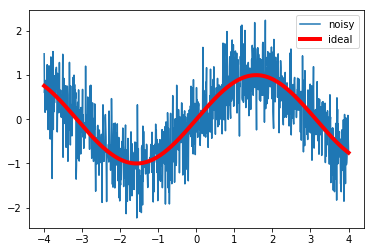

In [6]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [7]:
kernel = [0.2, 0.2, 0.2, 0.2, 0.2]

In [8]:
def plot_signal (kernel):
    x = np.linspace(-4, 4, 1000)
    signal = np.sin(x)
    noisy_signal = signal + np.random.randn(signal.shape[0])
    plt.plot(x, noisy_signal, label='noisy')
    plt.plot(x, signal, 'r', label='ideal', linewidth=4)
    denoised_signal = t_convolve(signal, kernel)
    k = len (kernel) / 2
    plt.plot(x[k:-k], denoised_signal, 'y', label='denoised')
    plt.xlabel ('dim:{} error:{}'.format (len (kernel), np.linalg.norm (signal[k:-k] - denoised_signal)))
    plt.legend(loc=0)
    plt.show ()

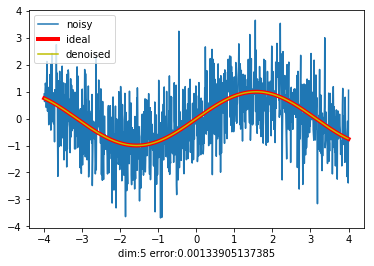

In [9]:
plot_signal (kernel)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

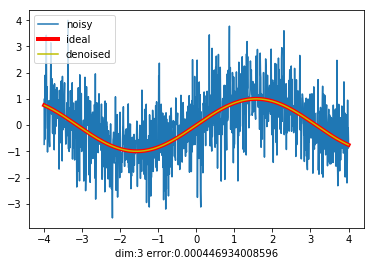

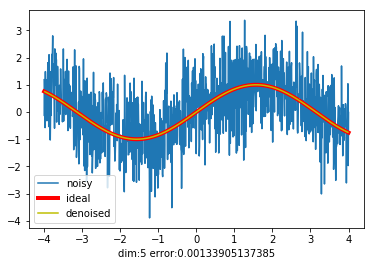

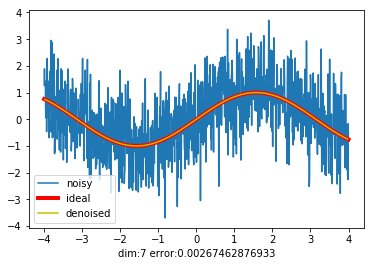

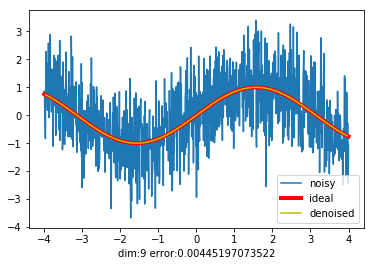

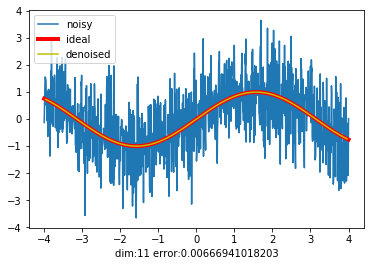

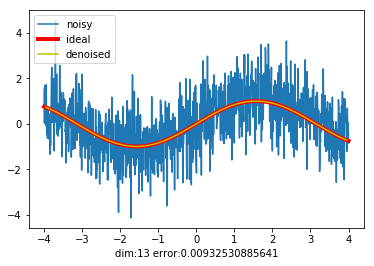

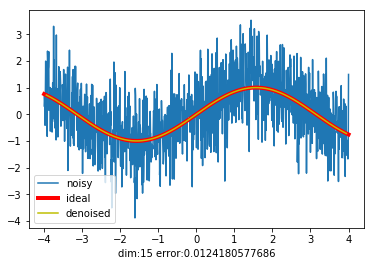

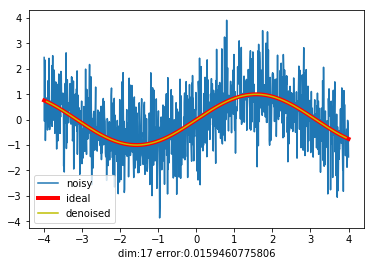

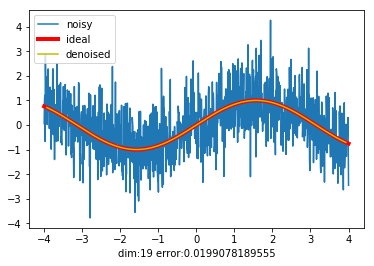

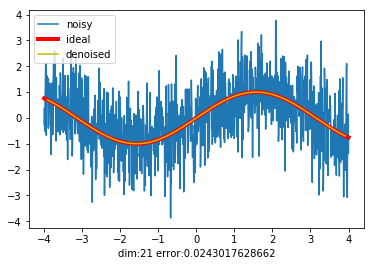

In [10]:
### YOUR CODE HERE #####
for i in range (3, 22, 2):
    kernel = [1. / i] * i
    plot_signal (kernel)
    

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

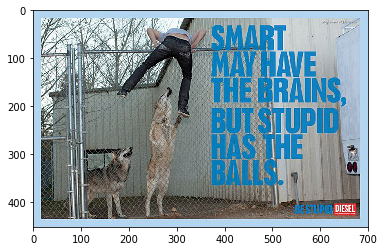

In [11]:
image = plt.imread('test_pic.jpg')
plt.imshow (image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [12]:
from scipy.signal import convolve
image.shape

(453, 700, 3)

In [13]:
color_to_bw = np.array ([[[1,1,1]]])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

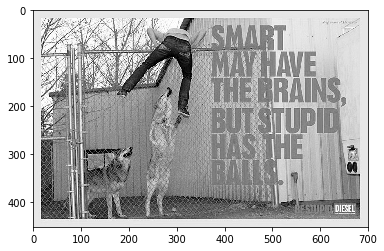

In [14]:
bw_image = convolve (image, color_to_bw, mode='valid')
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image[:,:,0], cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

Есили применять фильтр Скобеля к цветному изображению, мы получим цветное изображение с найдеными границами для каждого цвета. Поэтому сначала привожу изображение в чернобелое усреднением цветов а затем применяю фильтр Скобеля

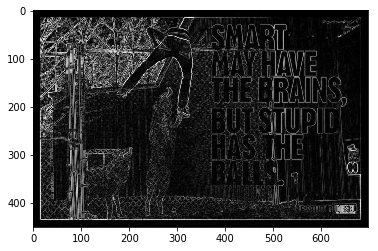

In [15]:
##### YOUR CODE HERE #####
slobel_b = [[[-1.],[-2],[-1]],
            [[0.], [0.], [0.]],
            [[1.], [2.], [1.]]]
slobel_l = [[[-1.],[0],[1]],
            [[-2.],[0],[2.]],
            [[-1.],[0],[1.]]]
bw_image = convolve (image, color_to_bw, mode='valid')
scobel_image_1 = convolve (bw_image, slobel_b, mode='valid')
scobel_image_2 = convolve (bw_image, slobel_l, mode='valid')
result_img = np.sqrt (scobel_image_1 ** 2 + scobel_image_2 ** 2)
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(result_img[:,:,0], cmap=plt.cm.Greys_r)

In [16]:
bw_image

array([[[632],
        [632],
        [632],
        ..., 
        [632],
        [632],
        [632]],

       [[632],
        [632],
        [632],
        ..., 
        [632],
        [632],
        [632]],

       [[632],
        [632],
        [632],
        ..., 
        [632],
        [632],
        [632]],

       ..., 
       [[632],
        [632],
        [632],
        ..., 
        [632],
        [632],
        [632]],

       [[632],
        [632],
        [632],
        ..., 
        [632],
        [632],
        [632]],

       [[632],
        [632],
        [632],
        ..., 
        [632],
        [632],
        [632]]])

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [14]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    ##### YOUR CODE HERE #####
    res_image = convolve (signal, kernel[0], mode='valid')
    print kernel[0]
    for i in range (1, kernel.shape[0]):
        res_image = np.append (convolve (signal, kernel[i], mode='valid'), res_image, axis=len(signal.shape) - 1)
    return res_image

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [15]:
##### YOUR CODE HERE #####
filter_bank = np.array ([
     [[[0,0,1]]],
     [[[0,1,0]]],
     [[[1,0,0]]]])

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

[[[0 0 1]]]


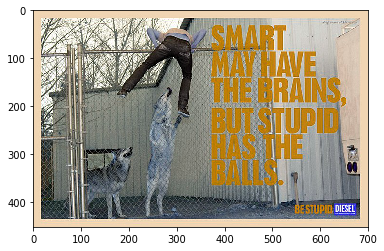

In [16]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))
swap_img = t_convolve_bank (image, filter_bank)
plt.imshow(swap_img.astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [17]:
def maxpool(image, dim):
    assert(image.ndim == 3)
    new_shape = (image.shape[0] / dim, image.shape[1] / dim, image.shape[2])
    new_img = np.zeros (new_shape)
    for c in range (new_img.shape[2]):
        for i in range (new_img.shape[0]):
            for j in range (new_img.shape[1]):
                maxi = image[i * dim, j * dim , c]
                for i_ in range (dim):
                    for j_ in range (dim):
                        if maxi < image[i * dim  + i_, j * dim+ j_, c]:
                            maxi = image[i*dim  + i_, j * dim+ j_, c]
                new_img[i,j,c] = maxi
    return new_img
                

def medianpool(image, dim):
    assert(image.ndim == 3)
    new_shape = (image.shape[0] / dim, image.shape[1] / dim, image.shape[2])
    new_img = np.zeros (new_shape)
    for c in range (new_img.shape[2]):
        for i in range (new_img.shape[0]):
            for j in range (new_img.shape[1]):
                temp = 0
                for i_ in range (dim):
                    for j_ in range (dim):
                        temp += image[i*dim  + i_, j * dim+ j_, c]
                new_img[i,j,c] = temp / (dim **2)
                
    return new_img

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

In [18]:
import random

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

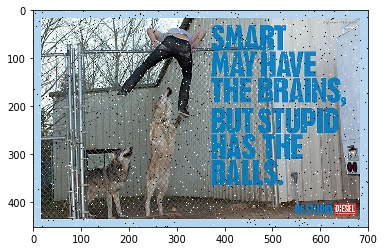

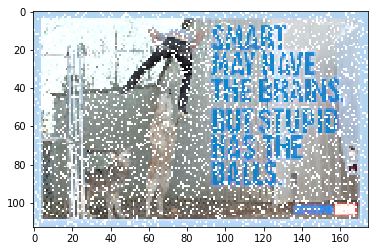

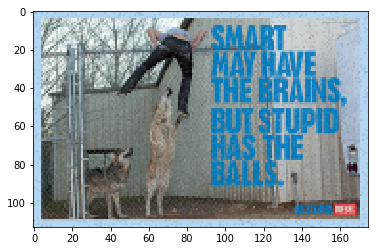

In [19]:
##### YOUR CODE HERE #####
salty = sp_noise (image, 0.01)
plt.imshow (salty)
plt.show ()
plt.imshow (maxpool (salty, 4).astype('uint8'))
plt.show ()
plt.imshow (medianpool (salty, 4).astype('uint8'))
plt.show ()

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Лучше подходит medianpooling потому, что соль это пиксели с максимальным значением и они перетягивают картинку на себя.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [20]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
%matplotlib inline

In [21]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [22]:
# пример сверточной сети
images_train = []
for x, y in train_loader:
    images_train = x
    labels_train = y
    break

print images_train.shape
    
image_size = images_train.size(2)
channels = images_train.size(1)
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*3, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        print x.data.shape
        x = x.view(x.size(0), -1)
        print x.data.shape
        x = self.linear_layers(x)
        return x

torch.Size([500, 1, 28, 28])


In [23]:
# пример forward pass
network = myConvNet()
batch_size = 10
X = Variable(images_train[:batch_size])
y = Variable(labels_train[:batch_size], requires_grad=False)
output = network.forward(X)

torch.Size([10, 3, 14, 14])
torch.Size([10, 588])


In [24]:
# а вот так можно сделать шаг обучения на этом батче
loss_fn = torch.nn.NLLLoss()

# о разных методах оптимизации мы поговорим на лекции 6
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(output, y)
print 'Current loss:', loss.data[0]

optimizer.zero_grad()
loss.backward()
optimizer.step()

Current loss: 2.3598241806


<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [25]:
##### YOUR CODE HERE #####
image_size = images_train.size(2)
channels = images_train.size(1)
class myConvNet_1(nn.Module):
    def __init__(self):
        super(myConvNet_1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(3136, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

<IPython.core.display.Javascript object>


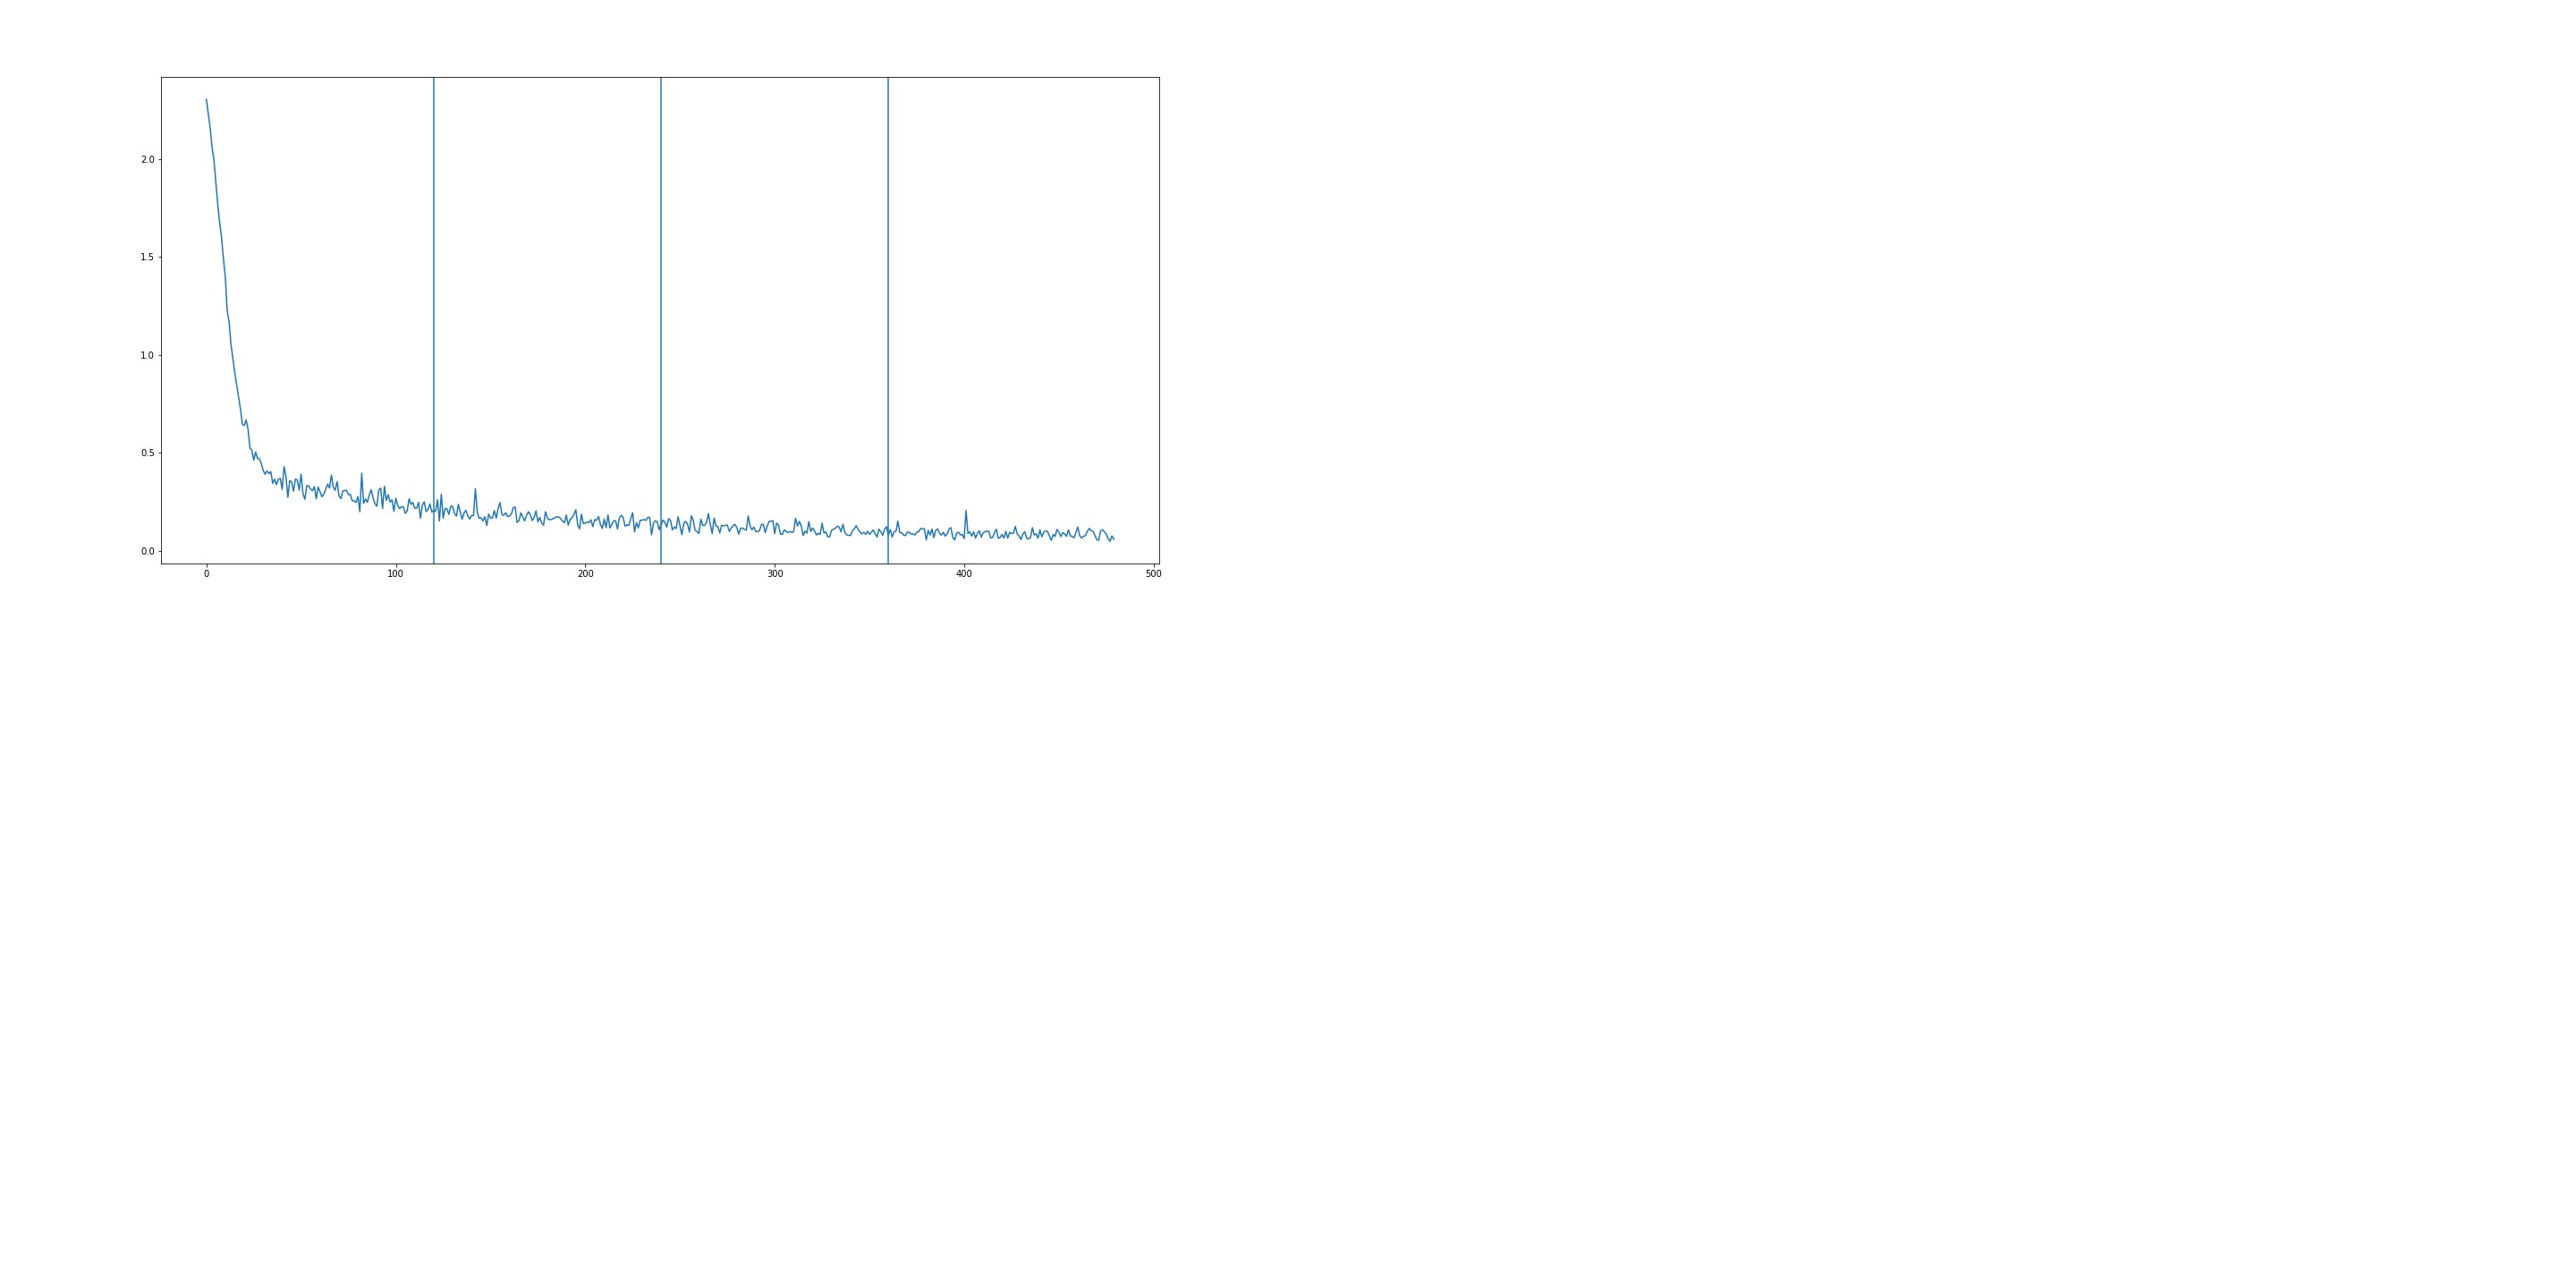

 Epoch: 3, Current loss: 0.0577311366796

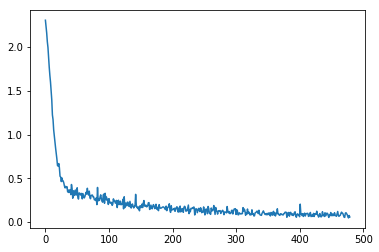

In [33]:
network = myConvNet_1()
batch_size = 10
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

%matplotlib notebook
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
plt.ion()

fig.show()
fig.canvas.draw()
loss_m = []
epoch_num = []

for epoch in range (4):
    for x, y in train_loader:
        optimizer.zero_grad()
        X = Variable(x)
        y = Variable(y, requires_grad=False)
        output = network.forward(X)
        loss = loss_fn(output, y)
        sys.stdout.write (('\r Epoch: {}, Current loss: {}').format (epoch, loss.data.mean ()))
        loss_m.append (loss.data.mean ())

        loss.backward()
        optimizer.step()
        
        ax.clear() # - Clear
        ax.plot (loss_m)
        for e in epoch_num:
            ax.axvline (e)
        
        fig.canvas.draw()
    epoch_num.append (len (loss_m))
    
%matplotlib inline
plt.plot (loss_m)



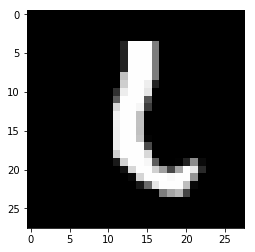

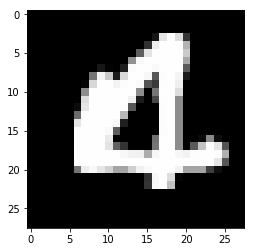

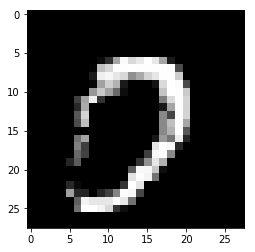

error mean: 0.0738170605204


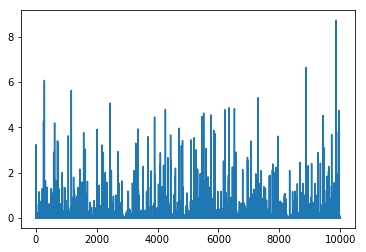

In [34]:
%matplotlib inline
error = []
top_errors = []
for x, y in test_loader:
        X = Variable(x)
        y = Variable(y, requires_grad=False)
        output = network.forward(X)
        loss = loss_fn(output, y)
        error.append (loss.data.mean ())
        if loss.data[0] >6:
            plt.imshow(X.data.numpy ().reshape(28, 28), cmap=plt.cm.Greys_r)
            plt.show ()
print "error mean:", np.array (error).mean ()
plt.plot (error)

In [28]:
image_size = images_train.size(2)
channels = images_train.size(1)
class myConvNet_2(nn.Module):
    def __init__(self):
        super(myConvNet_2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(1568, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

<IPython.core.display.Javascript object>


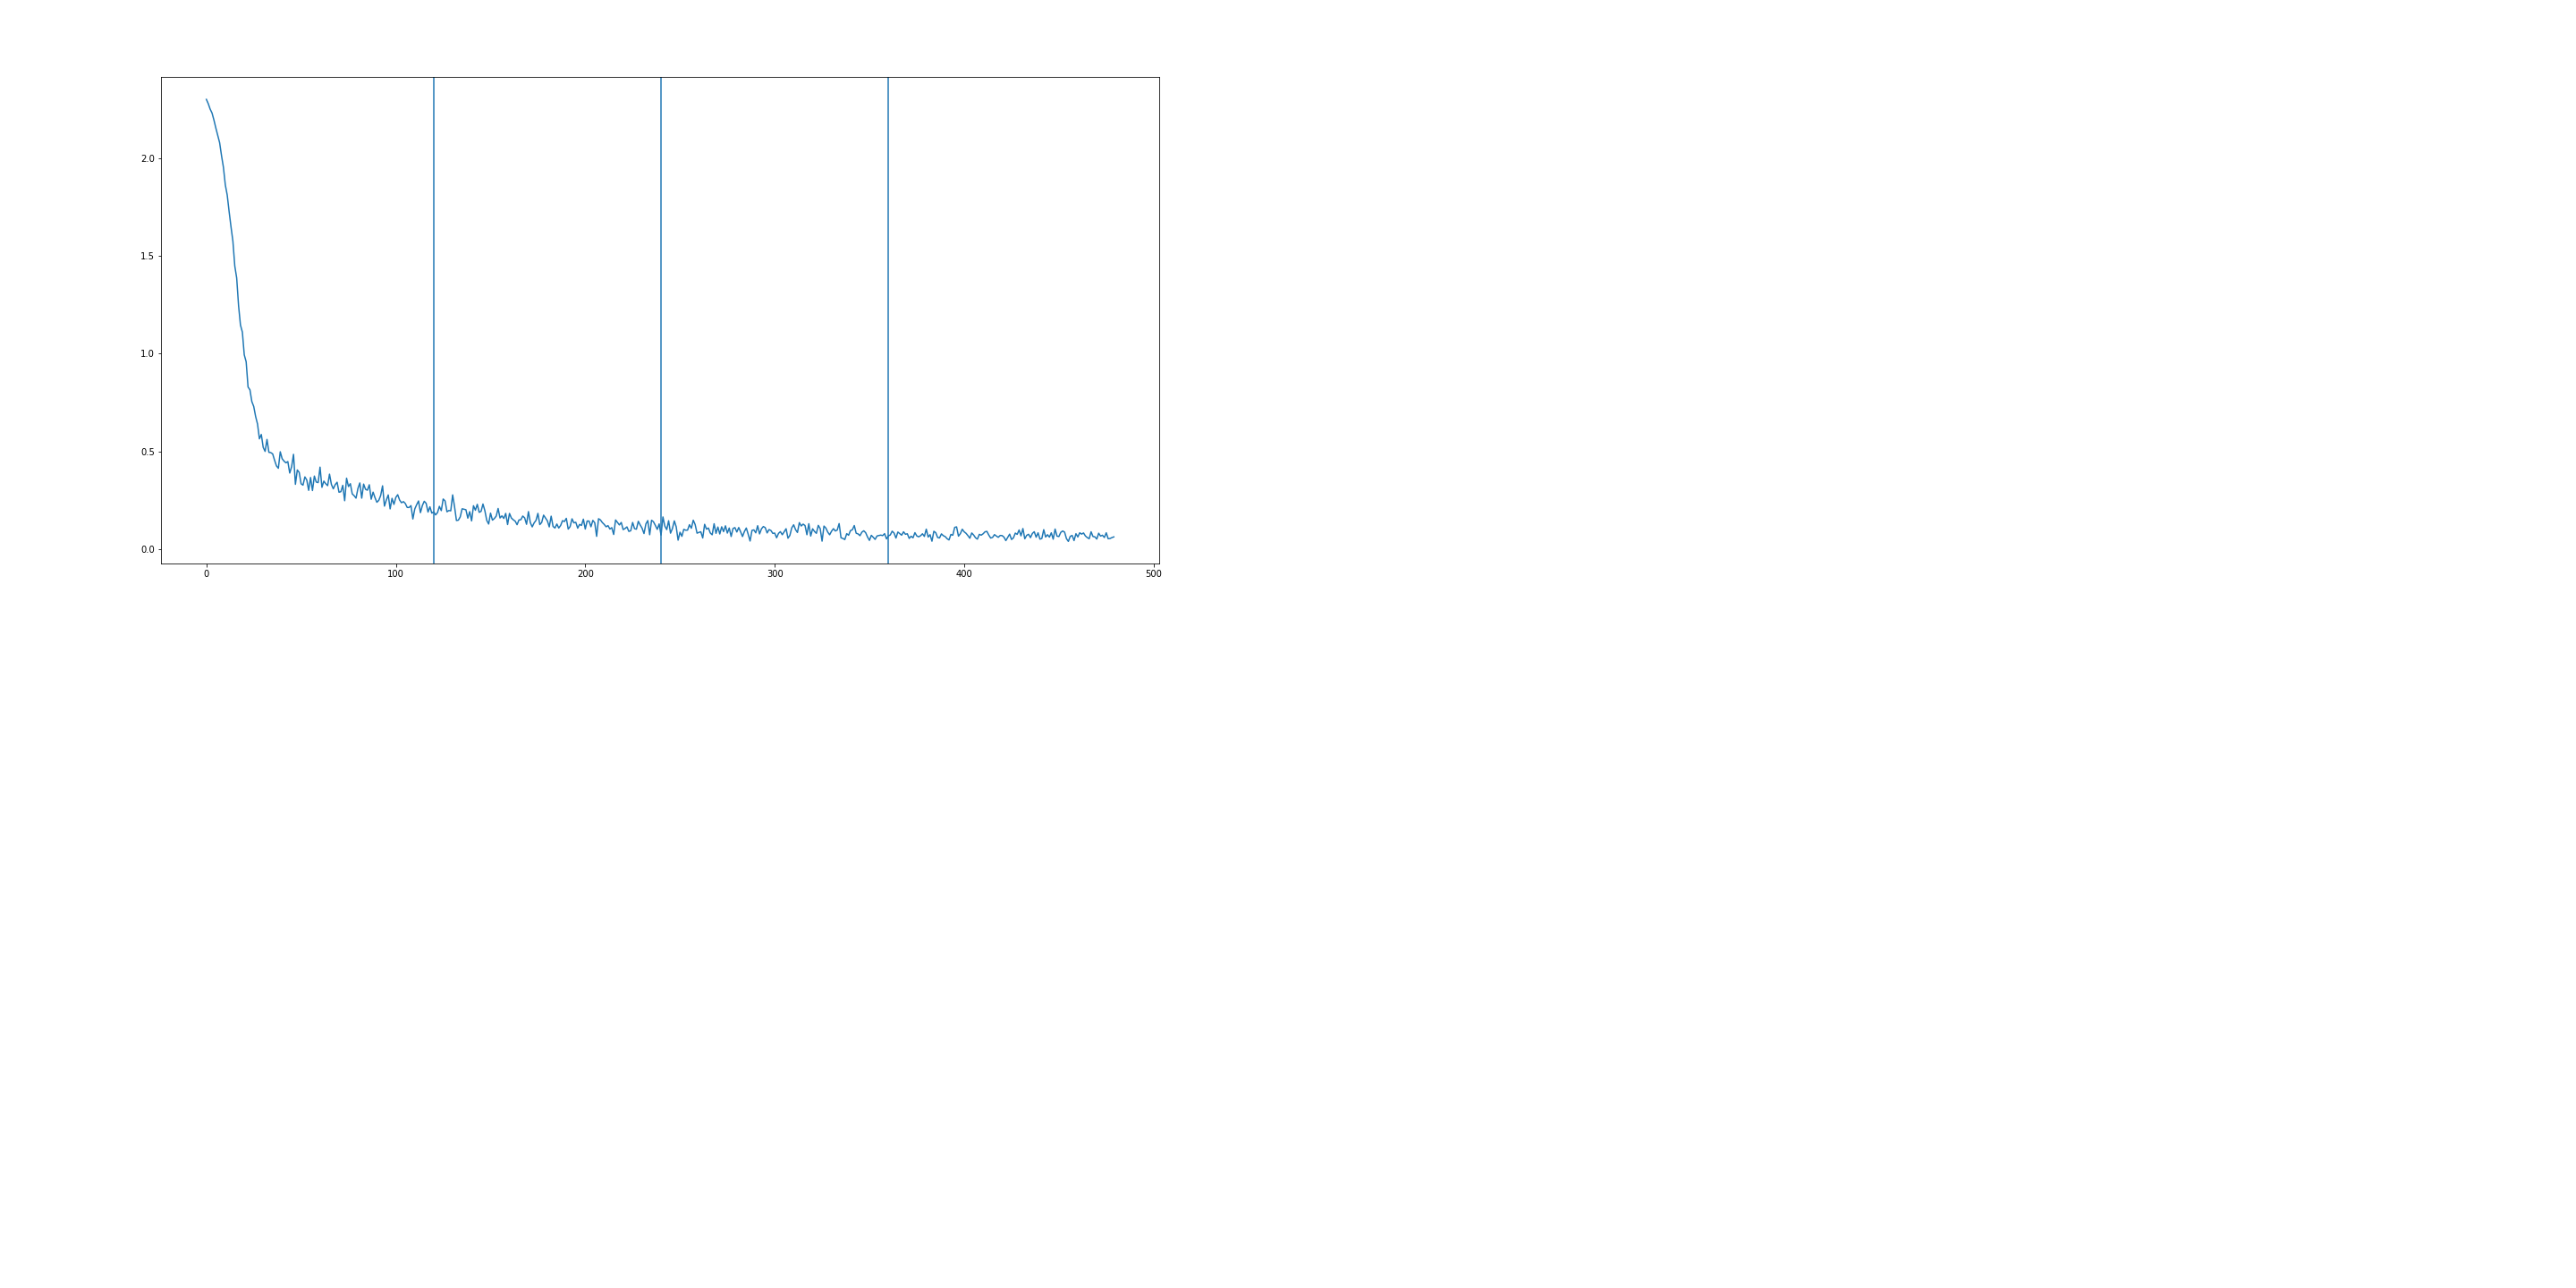

 Epoch: 3, Current loss: 0.0619063712656

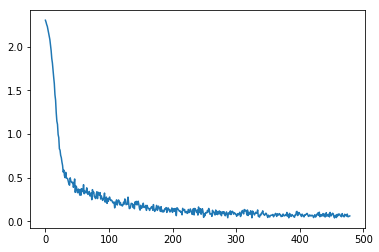

In [29]:
network = myConvNet_2()
batch_size = 10
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

%matplotlib notebook
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
plt.ion()

fig.show()
fig.canvas.draw()

loss_m = []
epoch_num = []

for epoch in range (4):
    for x, y in train_loader:
        optimizer.zero_grad()
        X = Variable(x)
        y = Variable(y, requires_grad=False)
        output = network.forward(X)
        loss = loss_fn(output, y)
        sys.stdout.write (('\r Epoch: {}, Current loss: {}').format (epoch, loss.data.mean ()))
        loss_m.append (loss.data.mean ())


        loss.backward()
        optimizer.step()
        
        ax.clear() # - Clear
        ax.plot (loss_m)
        for e in epoch_num:
            ax.axvline (e)
        
        fig.canvas.draw()
    epoch_num.append (len (loss_m))

%matplotlib inline
plt.plot (loss_m)



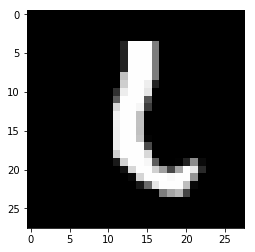

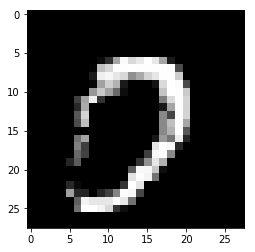

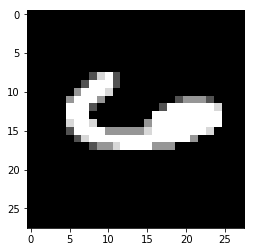

error mean: 0.0589071990773


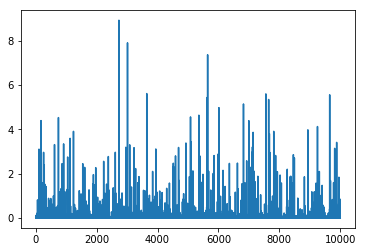

In [30]:
%matplotlib inline
error = []
top_errors = []
for x, y in test_loader:
        X = Variable(x)
        y = Variable(y, requires_grad=False)
        output = network.forward(X)
        loss = loss_fn(output, y)
        error.append (loss.data.mean ())
        if loss.data[0] >6:
            plt.imshow(X.data.numpy ().reshape(28, 28), cmap=plt.cm.Greys_r)
            plt.show ()
print "error mean:", np.array (error).mean ()
plt.plot (error)

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

Объекты с максимальной ошибкой выведены при расчете ошибки на тестовой выборке для каждой модели

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

добавление слоя улучшило результат! почему бы не попробовать добавить еще один?

<IPython.core.display.Javascript object>


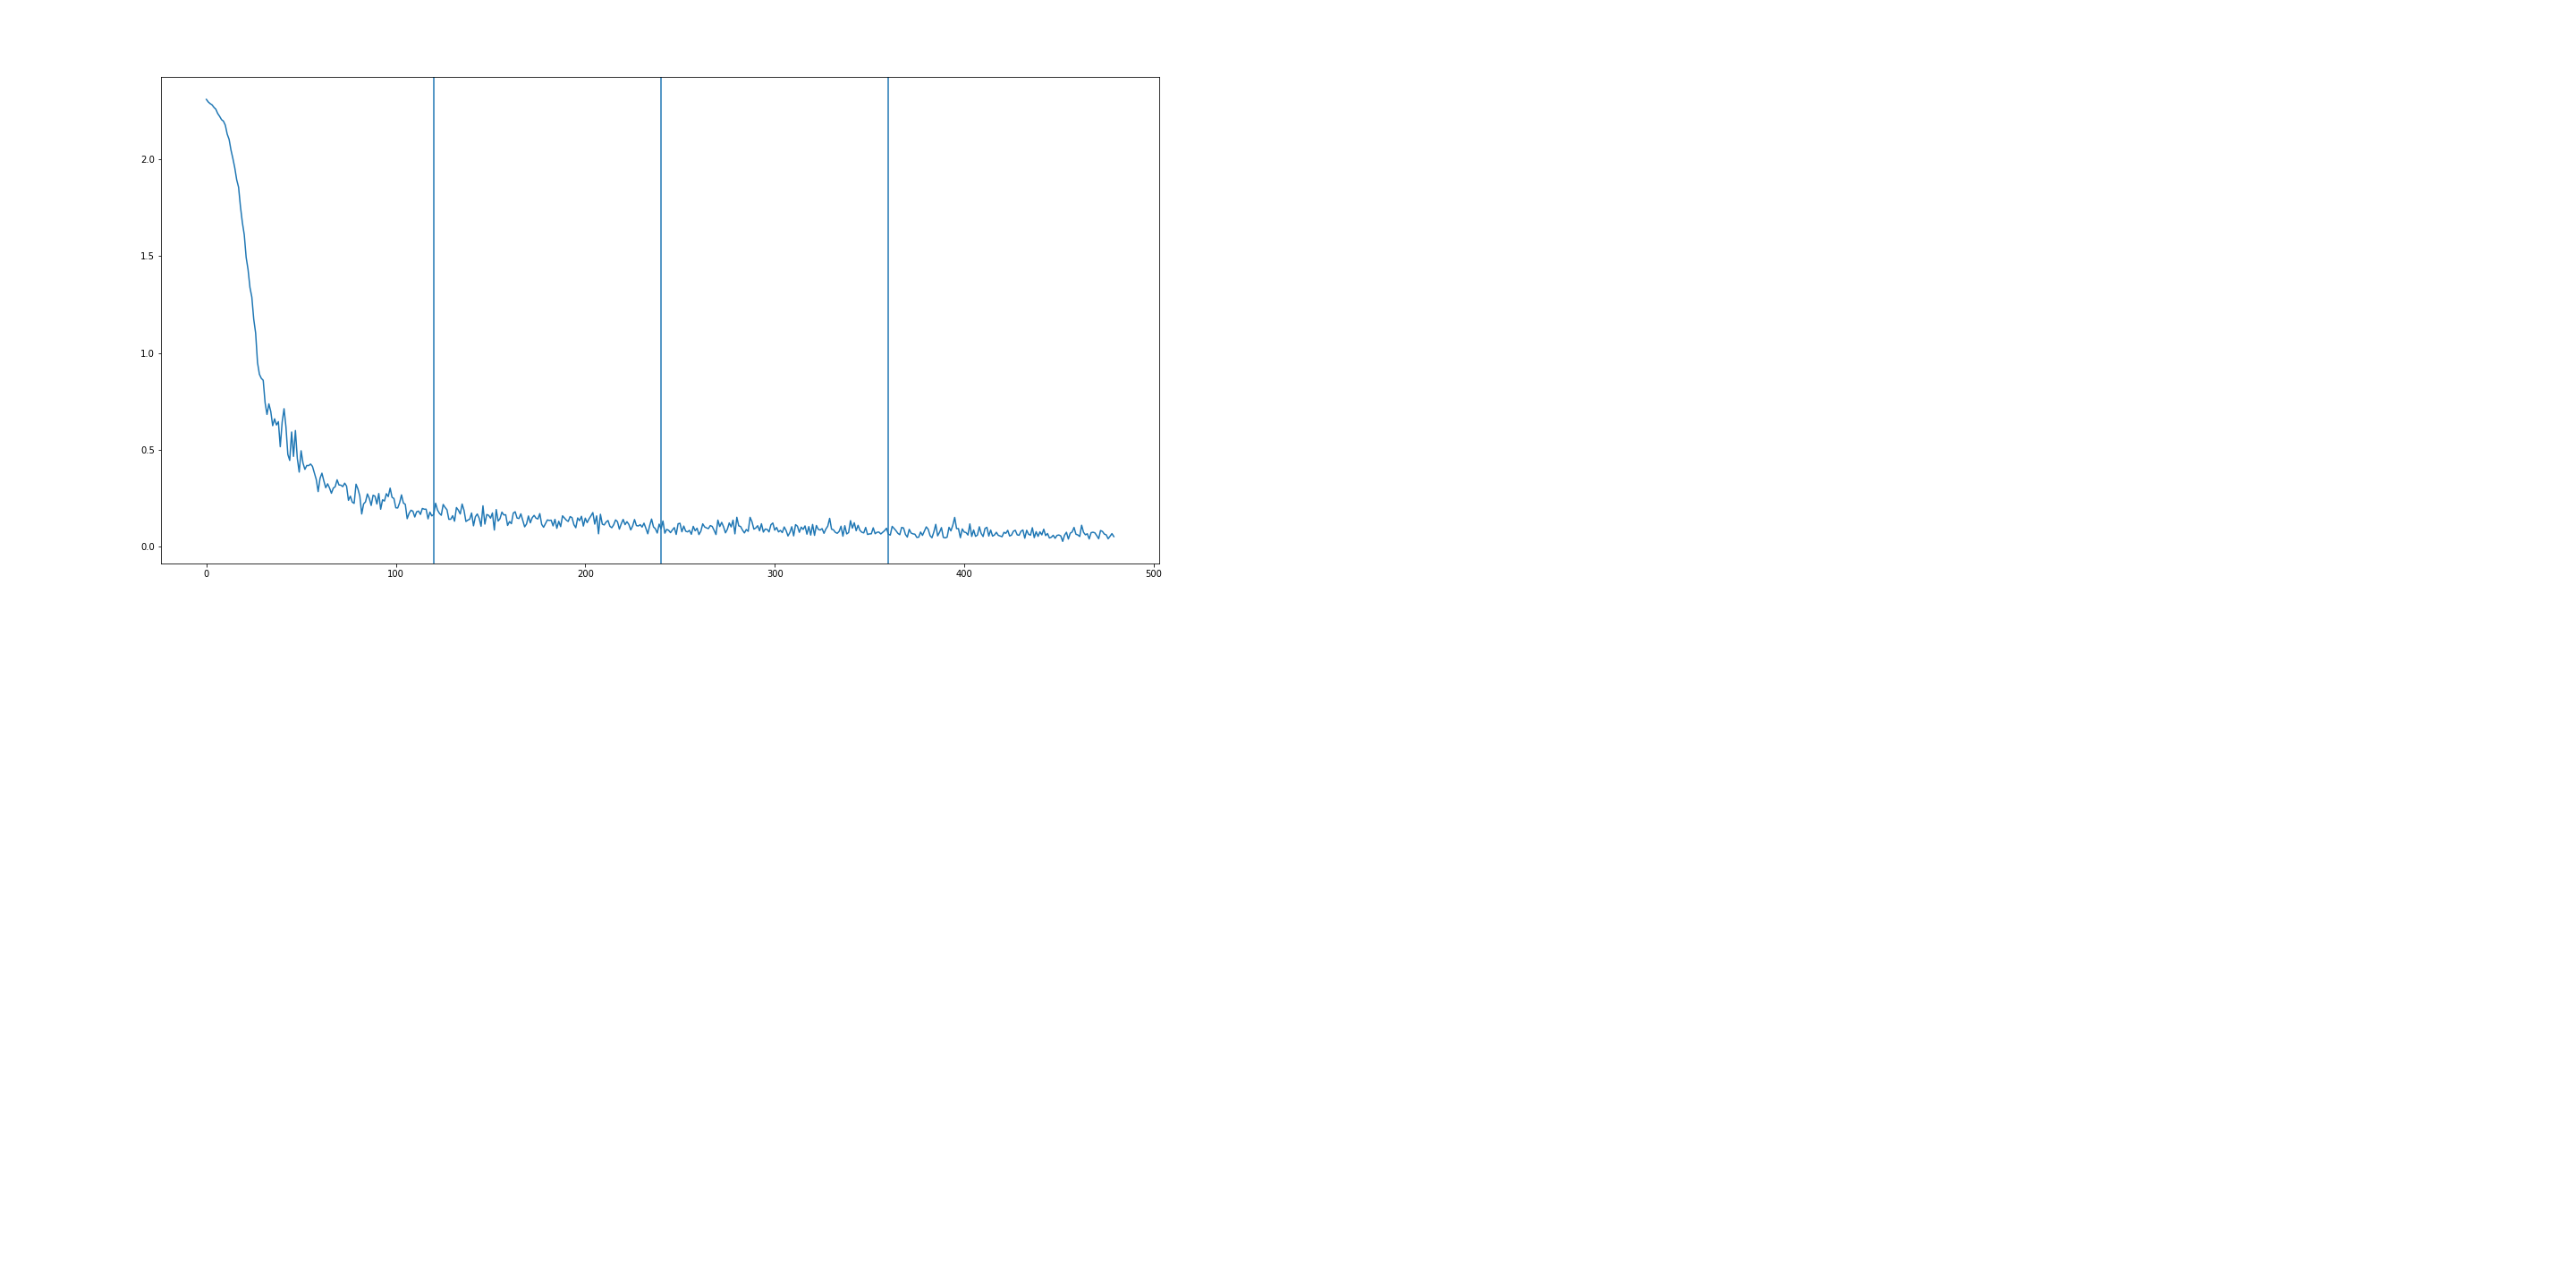

 Epoch: 3, Current loss: 0.0520351603627

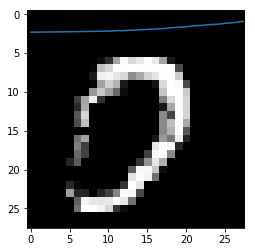


error mean: 0.0580590072437


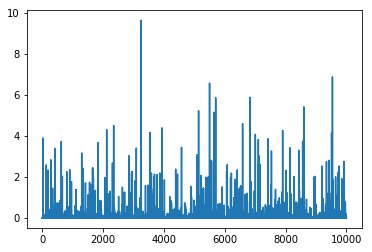

In [32]:
##### YOUR CODE HERE #####
image_size = images_train.size(2)
channels = images_train.size(1)
class myConvNet_3(nn.Module):
    def __init__(self):
        super(myConvNet_3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(576, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
network = myConvNet_3()
    
batch_size = 10
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

%matplotlib notebook
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
plt.ion()

fig.show()
fig.canvas.draw()

loss_m = []
epoch_num = []

for epoch in range (4):
    for x, y in train_loader:
        optimizer.zero_grad()
        X = Variable(x)
        y = Variable(y, requires_grad=False)
        output = network.forward(X)
        loss = loss_fn(output, y)
        sys.stdout.write (('\r Epoch: {}, Current loss: {}').format (epoch, loss.data.mean ()))

        loss.backward()
        optimizer.step()
        loss_m.append (loss.data.mean ())
        
        ax.clear() # - Clear
        ax.plot (loss_m)
        for e in epoch_num:
            ax.axvline (e)
        
        fig.canvas.draw()
    epoch_num.append (len (loss_m))

%matplotlib inline
plt.plot (loss_m)

error = []
top_errors = []
for x, y in test_loader:
        X = Variable(x)
        y = Variable(y, requires_grad=False)
        output = network.forward(X)
        loss = loss_fn(output, y)
        error.append (loss.data.mean ())
        if loss.data[0] > 8:
            plt.imshow(X.data.numpy ().reshape(28, 28), cmap=plt.cm.Greys_r)
            plt.show ()
print "\nerror mean:", np.array (error).mean ()
plt.plot (error)

##### Получилось отлично!

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: